# How to Classify Satellite Images

### Loading Libraries

In [37]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

#
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Warnings
import warnings

# Path
from pathlib import Path

# TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
%matplotlib inline

In [31]:
sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

In [33]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [39]:
results_path = Path ('results', 'eurosat')

if not results_path.exists():
    results_path.mkdir(parents=True)

### Loading EuroSat Dataset

In [44]:
(raw_train, raw_validation), metadata = tfds.load(
    'eurosat',
    split=['train[:90%]', 'train[90%:]'],
    with_info=True,
    shuffle_files=False,
    as_supervised=True,
    data_dir='../data/tensorflow'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

### Inspecting MetaData

In [47]:
metadata

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='../data/tensorflow/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=(

In [49]:
print('Train:\t', raw_train)

print('Valid:\t', raw_validation)

Train:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Valid:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


#### Showing Sample Images

2025-05-03 08:49:01.466210: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


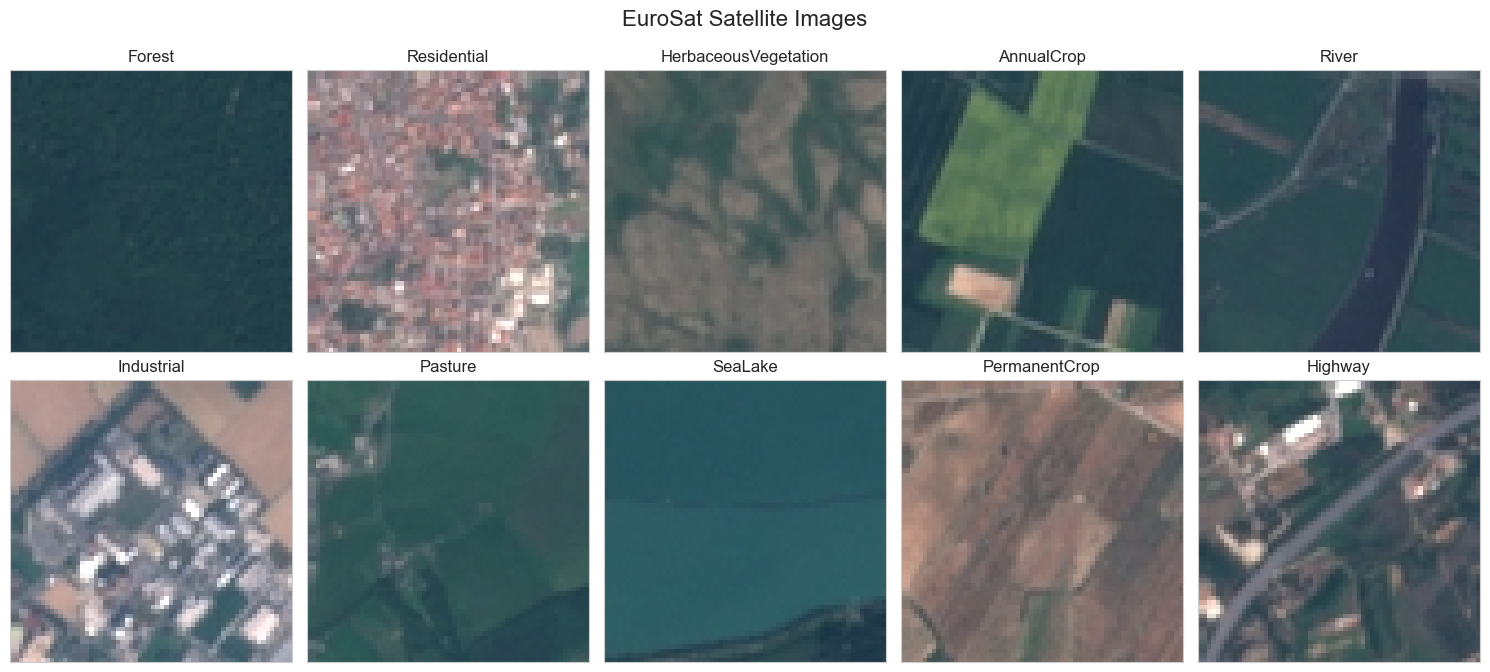

In [52]:
fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
axes = axes.flatten()
get_label_name = metadata.features['label'].int2str
labels = set()
c = 0
for img, label in raw_train.as_numpy_iterator():
    if label not in labels:
        axes[c].imshow(img)
        axes[c].set_title(get_label_name(label))
        axes[c].grid(False)
        axes[c].tick_params(axis='both', 
                            which='both', 
                            bottom=False, 
                            top=False, 
                            labelbottom=False, 
                            right=False, 
                            left=False, 
                            labelleft=False)
        labels.add(label)
        c += 1
        if c == 10:
            break
fig.suptitle('EuroSat Satellite Images', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.92);
# fig.savefig(results_path / 'eurosat_samples', dpi=300);
plt.show()

### Preprocessing

In [72]:
IMG_SIZE = 64

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [74]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    return image, label

In [76]:
train = raw_train.map(format_example)

validation = raw_validation.map(format_example)

In [78]:
BATCH_SIZE = 32

SHUFFLE_BUFFER_SIZE = 1000

In [80]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

validation_batches = validation.batch(BATCH_SIZE)

In [82]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

2025-05-03 08:53:32.810450: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-03 08:53:32.812226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([32, 64, 64, 3])

### Loading The DenseNet201 Bottleneck Features

In [85]:
densenet = DenseNet201(input_shape=IMG_SHAPE, 
                       include_top=False, 
                       weights='imagenet',
                       pooling='max',
                       classes=1000)

densenet.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 16, 16,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 16, 16,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 16, 16,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 16, 16,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 16, 16,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 16, 16,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [87]:
feature_batch = densenet(image_batch)

feature_batch.shape

TensorShape([32, 1920])

In [88]:
len(densenet.layers)

708

#### Adding New Layers to Model

In [92]:
model = Sequential([
    densenet,
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

In [94]:
for layer in model.layers:
    layer.trainable = True

In [100]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 1920)           │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     3,934,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,906,186 (133.16 MB)

 Trainable params: 34,656,906 (132.21 MB)

 Non-trainable params: 249,280 (973.75 KB)

#### Computing Baseline Metrics

In [105]:
initial_epochs = 10
validation_steps = 20

initial_loss, initial_accuracy = model.evaluate(validation_batches, steps = validation_steps)

2025-05-03 08:55:35.916861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.0833 - loss: 3175.7200


2025-05-03 08:55:41.510293: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [106]:
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

Initial loss: 3175.72 | initial_accuracy accuracy: 8.28%


### Training Model

#### Defining Callbacks

In [110]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10)

In [116]:
# eurosat_path = (results_path / 'cnn.weights.best.hdf5').as_posix()

# checkpointer = ModelCheckpoint(
#     filepath=eurosat_path,
#     verbose=1,
#     monitor='val_accuracy',
#     save_best_only=True,
#     save_weights_only=True  
# )

In [118]:
epochs = 100

In [ ]:
history = model.fit(train_batches,
                    epochs=epochs,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

#### Plotting Learning Curves

In [ ]:
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['accuracy', 'val_accuracy']].plot(ax=axes[0], title='Accuracy')
    df[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    fig.tight_layout();

In [ ]:
metrics = pd.DataFrame(history.history)
metrics.index = metrics.index.to_series().add(1)

fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics[['accuracy', 'val_accuracy']].plot(ax=axes[0], 
                                           title=f'Accuracy (Best: {metrics.val_accuracy.max():.2%})')
axes[0].axvline(metrics.val_accuracy.idxmax(), ls='--', lw=1, c='k')
metrics[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy', logy=True)
for ax in axes:
    ax.legend(['Training', 'Validation'])
    ax.set_xlabel('Epoch')
    
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'satellite_accuracy', dpi=300);
plt.show()